In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logomaker as lm
import torch
import gpmap.src.plot.mpl as plot
import gpmap.src.plot.ds as dplot
import logomaker

from collections import defaultdict
from itertools import combinations, product
from os.path import join
from tqdm import tqdm
from pysam import Fastafile
from scipy.stats import pearsonr, spearmanr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWalk
from gpmap.src.inference import SeqDEFT, VCregression, MinimumEpistasisInterpolator, MinimumEpistasisRegression
from gpmap.src.plot.mpl import plot_hyperparam_cv
from gpmap.src.utils import read_edges

### Extract Shine-Dalgarno sequences from _E.coli_ 5'UTRs

In [2]:
# Define auxiliary functions
def reverse_complement(seq):
    COMPLEMENT = {'A': 'U', 'T': 'A', 'U': 'A', 'G': 'C', 'C': 'G'}
    return(''.join(COMPLEMENT.get(x, x) for x in seq[::-1]))


def get_seq(genome, chrom, start, end, strand):
    seq = genome.fetch(chrom, start, end)
    if strand == '-':
        seq = reverse_complement(seq)
    
    return(seq.upper())


def read_gtf(gtf_fpath):
    with open(gtf_fpath) as fhand:
        for line in fhand:
            if line.startswith('#'):
                continue
            items = line.strip().split('\t')
            if items[2] != 'start_codon':
                continue
            chrom, strand = items[0], items[6]
            start, end = int(items[3]) - 1, int(items[4])
            attrs = dict(x.strip().split(' ') for x in items[-1].strip('";').split(';'))
            gene_id = attrs['gene_id'].strip('"')
            yield(chrom, start, end, strand, gene_id)


def get_upstream_coords(start, end, flanking_bases):
    start, end = start - flanking_bases, end + flanking_bases
    start = max(start, 0)
    return(start, end)


def get_SD_seqs(annotation, genome, seq_length, upstream_bases=20, sd_start=7):
    for chrom, start, end, strand, gene_id in annotation:
        

        start, end = get_upstream_coords(start, end, upstream_bases)
        seq = get_seq(genome, chrom, start, end, strand).replace('T', 'U')
        sd_seq = seq[sd_start:sd_start+seq_length]
        start_codon = seq[upstream_bases:upstream_bases + 3]

        if len(seq) < 2 * upstream_bases + 3 or 'N' in seq:
            continue
        
        record = {'gene_id': gene_id,
                  'start': start, 'end': end, 
                  'strand': strand, 'SD': sd_seq, 'start_codon': start_codon,
                  'background': seq}
        yield(record)

In [7]:
upstream_bases = 20
distance_start_codon = 4
seq_length = 9
sd_start = upstream_bases - distance_start_codon - seq_length

genome_fpath = join('genome', 'Escherichia_coli_gca_001263735.ASM126373v1.dna.toplevel.fa')
gtf_fpath  = join('genome', 'Escherichia_coli_gca_001263735.ASM126373v1.51.gtf')

genome = Fastafile(genome_fpath)
annotation = read_gtf(gtf_fpath)
gene_SD = get_SD_seqs(annotation, genome, seq_length=seq_length, 
                        upstream_bases=upstream_bases, sd_start=sd_start)

gene_SD = pd.DataFrame(gene_SD)
gene_SD

,gene_id,start,end,strand,SD,start_codon,background
0,AKG99_04255,735,778,-,AUCAGUCUC,AUG,GUUUGUCAUCAGUCUCGAAUAUGGUCGAUAUGAAAACUACGCA
1,AKG99_04260,3141,3184,-,CAGGAAUAA,AUG,AAAAAUGCAGGAAUAAAACAAUGAACAAGAAGAUUCAUUCCCU
2,AKG99_04265,3386,3429,+,AUGGGGUUA,GUG,AGUAAACAUGGGGUUAUGGUGUGACGGCGUUAAAAGUAGGAAG
3,AKG99_04270,4591,4634,+,ACAGGAGUU,AUG,UUCCAUGACAGGAGUUGAAUAUGGCAUUCAGUAAUCCCUUCGA
4,AKG99_04275,4806,4849,+,UGCAGGAGG,AUG,ACCCAGUUGCAGGAGGCACAAUGAGCCAGCAUUUACCUUUGGU
...,...,...,...,...,...,...,...
5306,AKG99_26250,111,154,+,UUCGGGGGU,AUG,GACCGCUUUCGGGGGUAAUGAUGUUUUUACGUCAGGAAGACUU
5307,AKG99_28250,214,257,-,CGAGGAAAA,GUG,CGUCGUGCGAGGAAAACAAGGUGAUUGACCAAAAUCGAAGUUA
5308,AKG99_27320,44,87,+,AGUUACAGU,UUG,UAACGGUAGUUACAGUAAUCUUGGAUCACACAGAGGAUCAUUU
5309,AKG99_27335,206,249,-,CCGUUGUCU,GUG,UCGUCAGCCGUUGUCUCCGGGUGUCGCGUGCGCAGUUGCACGU


In [8]:
# Store gene data
gene_SD.to_csv('data/gene_data.csv')

# Save sequences alone
with open('data/SD_seqs.txt', 'w') as fhand:
        for seq in gene_SD['SD']:
            fhand.write('{}\n'.format(seq))

### Descriptive analysis

In [9]:
sd_seqs = [line.strip() for line in open('data/SD_seqs.txt')]
unique_seqs, counts = np.unique(sd_seqs, return_counts=True)
max_counts = counts.max()
print('Total number of sequences: {}'.format(len(sd_seqs)))
print('Total number of unique sequences: {}'.format(unique_seqs.shape[0]))
print('Total number of unobserved sequences: {}'.format(4**9 - unique_seqs.shape[0]))
print('Max number of times a sequences was observed: {}'.format(max_counts))

Total number of sequences: 5311
Total number of unique sequences: 4449
Total number of unobserved sequences: 257695
Max number of times a sequences was observed: 9


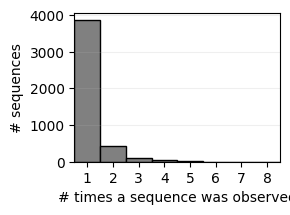

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(3., 2.25))
axes.hist(counts, color='grey', lw=1, edgecolor='black', align='mid', bins=max_counts-1)
xticklabels = np.arange(1, max_counts)
xticks = 0.5 + xticklabels
axes.set(xlim=(1, max_counts), ylabel='# sequences',
         xlabel='# times a sequence was observed',
         xticks=xticks, xticklabels=xticklabels)
axes.grid(alpha=0.2, axis='y')
fig.tight_layout()
fig.savefig('figures/count_distribution.svg')

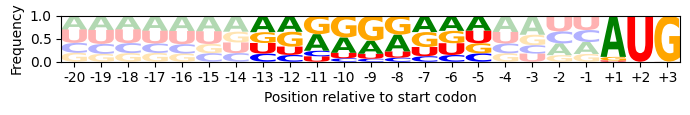

In [11]:
# Include more bases upstream and downstream to fill a whole row: shade all other regions
upstream_bases = 20
gene_data = pd.read_csv('data/gene_data.csv', index_col=0)
background_seqs = [x[:-upstream_bases] for x in gene_data['background']]
allele_freqs = logomaker.alignment_to_matrix(background_seqs, to_type='probability', pseudocount=0)

fig, axes = plt.subplots(1, 1, figsize=(7, 1.25))

logo = logomaker.Logo(allele_freqs, ax=axes)
for p in list(range(sd_start)) + list(range(sd_start + seq_length, 20)):
    for c in 'AUGC':
        logo.style_single_glyph(p, c, alpha=0.3)

xticks = np.arange(allele_freqs.shape[0])
xticklabels = ['-{}'.format(x) for x in range(1, 21)[::-1]] + ['+1', '+2', '+3']
axes.set(ylabel='Frequency',
         xlabel='Position relative to start codon',
         xticks=xticks, xticklabels=xticklabels,
         yticks=[0, 0.5, 1])
fig.tight_layout()
fig.savefig('figures/SD_sequence_logo.svg')

### Infering SeqDEFT model hyperparameter

In [12]:
X = np.array(sd_seqs)

In [8]:
model = SeqDEFT(P=2, seq_length=9, alphabet_type='rna')
model.fit(X=X)

  5%|▌         | 6/115 [02:46<1:02:01, 34.14s/it]

In [ ]:
model.logL_df.to_csv('data/seqdeft_hyperparam_optimization.csv')
with open('data/optimal_a.txt', 'w') as fhand:
    fhand.write('{}'.format(model.a))

### Probability distribution inference

In [22]:
from gpmap.src.linop import DeltaPOperator
from gpmap.src.matrix import quad

In [4]:
with open('data/optimal_a.txt', 'r') as fhand:
    optimal_a = float([line.strip() for line in fhand][0])
    model = SeqDEFT(P=2, a=optimal_a, seq_length=9, alphabet_type='rna')

In [13]:
inferred = model.fit(X=X)
inferred['counts'] = inferred['frequency'] * len(sd_seqs)
inferred

,frequency,phi,Q_star,counts
AAAAAAAAA,0.000000,11.052962,1.582898e-05,0.0
AAAAAAAAC,0.000000,11.552719,9.603085e-06,0.0
AAAAAAAAG,0.000000,11.368461,1.154605e-05,0.0
AAAAAAAAU,0.000000,11.113094,1.490520e-05,0.0
AAAAAAACA,0.000000,11.817456,7.369483e-06,0.0
...,...,...,...,...
UUUUUUUGU,0.000000,14.847550,3.560278e-07,0.0
UUUUUUUUA,0.000000,14.350043,5.855292e-07,0.0
UUUUUUUUC,0.000000,15.068305,2.855035e-07,0.0
UUUUUUUUG,0.000000,14.957307,3.190196e-07,0.0


In [13]:
inferred.to_csv('data/seqdeft_inference.csv')

### Plotting SeqDEFT results

In [39]:
with open("data/optimal_a.txt", "r") as fhand:
    optimal_a = float([line.strip() for line in fhand][0])
print('Optimal a*={:.2f}'.format(model.a))
print('Expected 1 / s * f^T D(P) f = {:.2f}'.format((model.DP.rank) / optimal_a))

Optimal a*=55985.76
Expected 1 / s * f^T D(P) f = 4.68


In [40]:
logL_df = pd.read_csv('data/seqdeft_hyperparam_optimization.csv', index_col=0)
inferred = pd.read_csv('data/seqdeft_inference.csv', index_col=0)

In [42]:
D1 = DeltaPOperator(4, 9, P=1)
D2 = DeltaPOperator(4, 9, P=2)
f = np.log(inferred["Q_star"])
map_mut_eff_var = quad(D1, f) / D1.n_p_faces
map_epi_coeff_var = quad(D2, f) / D2.n_p_faces
print('Avg squared mutational effects in the MAP: {:2f}'.format(map_mut_eff_var))
print("Avg squared epistatic coefficients in the MAP: {:2f}".format(map_epi_coeff_var))

Avg squared mutational effects in the MAP: 0.614377
Avg squared epistatic coefficients in the MAP: 0.104851


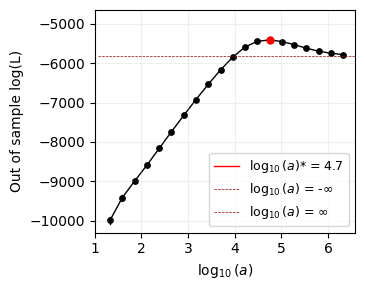

In [43]:
fig, axes = plt.subplots(1, 1, figsize=(3.75, 3.0))

plot_hyperparam_cv(logL_df, axes, show_folds=False)
axes.set(xticks=np.arange(1, 7))
axes.legend(loc=4, fontsize=9)
axes.grid(alpha=0.2)

fig.tight_layout()
fig.savefig('figures/seqdeft_hyperparameter_opt.svg')

In [44]:
inferred['logQ'] = np.log10(inferred['Q_star'])
inferred

,frequency,phi,Q_star,counts,logQ
AAAAAAAAA,0.000000,11.052221,1.584592e-05,0.0,-4.800083
AAAAAAAAC,0.000000,11.552030,9.612871e-06,0.0,-5.017147
AAAAAAAAG,0.000000,11.367442,1.156162e-05,0.0,-4.936981
AAAAAAAAU,0.000000,11.112202,1.492341e-05,0.0,-4.826132
AAAAAAACA,0.000000,11.816932,7.375773e-06,0.0,-5.132192
...,...,...,...,...,...
UUUUUUUGU,0.000000,14.847877,3.560284e-07,0.0,-6.448515
UUUUUUUUA,0.000000,14.352378,5.843556e-07,0.0,-6.233323
UUUUUUUUC,0.000000,15.070527,2.849634e-07,0.0,-6.545211
UUUUUUUUG,0.000000,14.958188,3.188432e-07,0.0,-6.496423


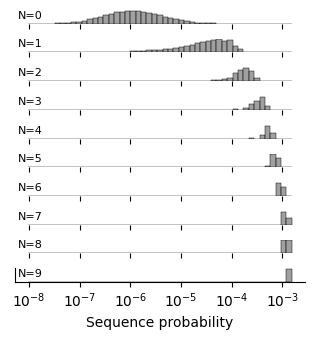

In [19]:
fig, subplots = plt.subplots(max_counts + 1, 1, figsize=(3.25, 3.5), sharex=True)
bins = np.linspace(inferred['logQ'].min(), inferred['logQ'].max(), 50)

for axes, (c, df) in zip(subplots, inferred.groupby('counts')):
    sns.histplot(df['logQ'], bins=bins, ax=axes, stat='percent', color='grey',
                 label='Estimated probability')
    sns.despine(ax=axes, bottom=True, left=True)
    ylim = axes.get_ylim()
    # axes.vlines(np.log10(df['frequency'][0]), 0, 100, color='black', lw=1.5, linestyle='-',
    #              label='Observed frequency')
    axes.set(ylabel='', yticklabels=[], yticks=[])
    axes.text(0.01, 0.95, 'N={}'.format(int(np.round(c, 0))), transform=axes.transAxes, ha='left', va='top', fontsize=8)

sns.despine(ax=axes, bottom=False)
xticks = np.arange(-8, -2)
xticklabels = ['$10^{-8}$', '$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$']
axes.set(xticks=xticks, xticklabels=xticklabels, xlabel='Sequence probability')
# subplots[0].legend(loc=(0.05, 1.05), fontsize=8)

fig.tight_layout()
fig.savefig('figures/seqdeft_probs.svg')

## Inference from high throughput experimental data

### Data preprocessing

In [14]:
samples = ['dmsC.1', 'dmsC.2', 'dmsC.3']
data = pd.read_csv('data/dmsc.csv', index_col=0, usecols=['Genotype'] + samples)
data['n_measured'] = np.sum(~np.isnan(data[samples]), axis=1)
data = data.loc[data['n_measured'] >= 1, :]
data['y'] = np.nanmean(data[samples], axis=1)

df = pd.melt(data.loc[data['n_measured'] > 1, samples + ['y']], id_vars=['y']).dropna()
sample_var = np.sum((df['value'] - df['y']) ** 2) / (df.shape[0] - data.shape[0])
data['y_var'] = sample_var / data['n_measured']
data.to_csv('data/dmsc_processed.csv')

In [15]:
# Split into test and training sets
np.random.seed(0)
u = np.random.uniform(size=data.shape[0])
train = data.loc[u < 0.999, :]
test = data.loc[u > 0.999, :]

X_train, y_train, y_var_train = train.index.values, train.y.values, train.y_var.values
X_test, y_test, y_var_test = test.index.values, test.y.values, test.y_var.values

print('Split into {} sequences for training and {} for testing'.format(X_train.shape[0], X_test.shape[0]))

Split into 257291 sequences for training and 274 for testing


### Inference with Minimum epistasis interpolation

In [9]:
model = MinimumEpistasisInterpolator(P=2)
model.set_data(X=X_train, y=y_train)
predictions = model.predict()
predictions.to_csv('data/minimum_epistasis_interpolation.csv')

### Inference with Minimum epistasis regression

In [5]:
model = MinimumEpistasisRegression(P=2, seq_length=9, alphabet_type='rna', num_reg=20,
                                   min_log_reg=np.log(5), max_log_reg=np.log(1e4),
                                   cg_rtol=1e-6)
model.fit(X=X_train, y=y_train, y_var=y_var_train, cross_validation=False)

100%|██████████| 36/36.0 [05:49<00:00,  9.72s/it]


In [11]:
a_opt = model.a
np.log10(a_opt)

6.4157810838093265

In [14]:
model.logL_df.to_csv("data/mer_hyperparameter_optimization.csv")
with open('data/mer.hyperparam_opt.txt', 'w') as fhand:
    fhand.write('{}'.format(model.a))

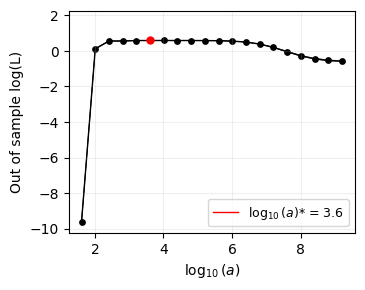

In [15]:
logL_df = pd.read_csv('data/mer_hyperparameter_optimization.csv', index_col=0)
fig, axes = plt.subplots(1, 1, figsize=(3.75, 3.0))
plot_hyperparam_cv(logL_df, axes, show_folds=True)
axes.legend(loc=4, fontsize=9)
axes.grid(alpha=0.2)

fig.tight_layout()
fig.savefig('figures/mer_hyperparameter_opt.svg')

In [19]:
with open("data/mer.hyperparam_opt.txt", "r") as fhand:
    a_opt = [float(x.strip()) for x in fhand][0] 
a_opt

4070.759094303203

In [12]:
model = MinimumEpistasisRegression(P=2, a=a_opt, seq_length=9, alphabet_type='rna')
model.set_data(X=X_train, y=y_train, y_var=y_var_train)
predictions = model.predict(X_test, calc_variance=True)
predictions.to_csv('data/minimum_epistasis_regression.csv')

100%|██████████| 274/274 [05:26<00:00,  1.19s/it]


### Inferring the genotype-phenotype map for the Shine-Dalgarno sequence using VC regression

In [12]:
# Compute the empirical correlation-distance function
model = VCregression(seq_length=9, alphabet_type='rna') #, beta=1e-2)
cov, ns = model.calc_covariance_distance(X=X_train, y=y_train - y_train.mean())
dcor = pd.DataFrame({'d': np.arange(cov.shape[0]),
                     'rho': cov / cov[0]})
dcor.to_csv('data/distance_correlation.csv')
dcor

,d,rho
0,0,1.000000
1,1,0.568012
2,2,0.376367
3,3,0.245857
4,4,0.152049
5,5,0.081908
6,6,0.027292
7,7,-0.017287
8,8,-0.055657
9,9,-0.090540


In [13]:
# Fit variance components
model.fit(X=X_train, y=y_train, y_var=y_var_train)

In [14]:
# Save variance components
vc = pd.DataFrame({'k': np.arange(1, model.lambdas.shape[0]),
                   'lambda_k': model.lambdas[1:],
                   'variance_perc': model.lambdas_to_variance(model.lambdas)* 100})
vc['cum_perc'] = np.cumsum(vc['variance_perc'])
vc.to_csv('data/variance_components.csv')
vc

,k,lambda_k,variance_perc,cum_perc
0,1,373.777526,34.797093,34.797093
1,2,20.420498,22.812735,57.609829
2,3,2.527750,19.767108,77.376937
3,4,0.287375,10.112773,87.489710
4,5,0.050127,5.291929,92.781639
5,6,0.016396,3.461801,96.243440
6,7,0.008550,2.321172,98.564612
7,8,0.005602,1.140652,99.705264
8,9,0.004343,0.294736,100.000000


In [15]:
# Infer full landscape under the prior
inferred = model.predict()
inferred

,y
AAAAAAAAA,0.563879
AAAAAAAAC,0.701486
AAAAAAAAG,0.619213
AAAAAAAAU,0.628787
AAAAAAACA,0.594647
...,...
UUUUUUUGU,0.615827
UUUUUUUUA,0.539003
UUUUUUUUC,0.548774
UUUUUUUUG,0.536575


In [289]:
# Save landscape
inferred.to_csv('data/inferred_vc_regression.csv')

In [290]:
test_pred = model.predict(X_pred=X_test, calc_variance=True)
test_pred

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [13:44<00:00,  3.01s/it]


,y,y_var,std,ci_95_lower,ci_95_upper
AAAAGCUCG,0.500930,0.014568,0.120698,0.259534,0.742325
AAAAUUCGU,0.612574,0.015019,0.122554,0.367467,0.857682
AAAGGUAGU,1.427321,0.014791,0.121620,1.184080,1.670561
AAAGUAGAG,0.702300,0.014790,0.121615,0.459070,0.945529
AAAUCCAAA,0.513293,0.014599,0.120828,0.271637,0.754949
...,...,...,...,...,...
UUGGCUUAA,0.525195,0.014687,0.121192,0.282811,0.767578
UUGGGCGGC,0.512812,0.014883,0.121996,0.268819,0.756804
UUGGUGGUC,0.955759,0.015101,0.122885,0.709989,1.201528
UUUGAGGUG,1.800311,0.015138,0.123039,1.554233,2.046388


In [291]:
# Save out of sample predictions
test_pred.to_csv('data/SD_test_pred.csv')

### Compare model performance on test data


In [45]:
data = pd.read_csv('data/dmsc_processed.csv', index_col=0)
mei = pd.read_csv('data/minimum_epistasis_interpolation.csv', index_col=0)
mer = pd.read_csv('data/minimum_epistasis_regression.csv', index_col=0)
vc = pd.read_csv('data/SD_test_pred.csv', index_col=0)

test_seqs = vc.index.values
r2s = {'MEI': pearsonr(mei.loc[test_seqs, 'y'], data.loc[test_seqs, 'y'])[0]**2,
       'MER': pearsonr(mer['y'], data.loc[test_seqs, 'y'])[0]**2,
       'VC': pearsonr(vc['y'], data.loc[test_seqs, 'y'])[0]**2}
r2s


{'MEI': 0.8577845362102886, 'MER': 0.8359006490624349, 'VC': 0.865565582678779}

In [46]:
def plot_scatter_pred(axes, test_pred):
    x = test_pred['y_obs']
    y = test_pred['y']
    r2 = pearsonr(y, x)[0] ** 2

    if 'std' in test_pred.columns:
        calibration = np.logical_and(test_pred['y_obs'] < test_pred['ci_95_upper'],
                                        test_pred['y_obs'] > test_pred['ci_95_lower']).mean()
        yerr = 2 * test_pred['std']
    else:
        yerr = None
        calibration = None

    axes.errorbar(x, y, yerr=yerr,
                color='black', fmt='o', alpha=0.2, markeredgewidth=0,
                markersize=5)
    axes.set(xticks=np.arange(4),
             ylabel='Test predicted log(GFP)', xlabel='Test measured log(GFP)')
    axes.axline((0, 0), (1, 1), lw=0.75, c='grey', linestyle='--')
    axes.grid(alpha=0.2)
    msg = '$R^2$' + '={:.2f}\n'.format(r2)
    if calibration is not None:
        msg += 'Calibration={:.1f}%\n'.format(calibration * 100)
    msg += 'n={}'.format(test_pred.shape[0])
    axes.text(0.05, 0.97, msg,
            transform=axes.transAxes, va='top', ha='left', fontsize=8)


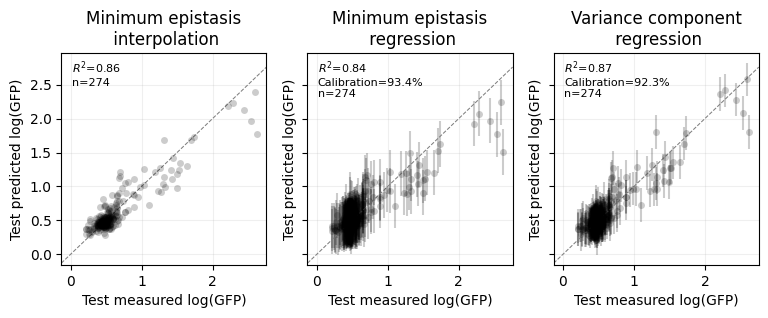

In [47]:
fig, subplots = plt.subplots(1, 3, figsize=(9, 2.75), sharex=True, sharey=True)

labels = ['Minimum epistasis\n interpolation',
          'Minimum epistasis\n regression',
          'Variance component\n regression']
datasets = [mei, mer, vc]
for label, dataset, axes in zip(labels, datasets, subplots):
    pred = dataset.loc[X_test, :]
    pred["y_obs"] = data.loc[X_test, 'y']
    plot_scatter_pred(axes, pred)
    axes.set(title=label)


### Visualize Variance Components

In [296]:
dcor = pd.read_csv('data/distance_correlation.csv', index_col=0)
dcor

,d,rho
0,0,1.000000
1,1,0.568012
2,2,0.376367
3,3,0.245857
4,4,0.152049
5,5,0.081908
6,6,0.027292
7,7,-0.017287
8,8,-0.055657
9,9,-0.090540


In [297]:
fig, axes = plt.subplots(1, 1, figsize=(2.75, 2.5))

axes.scatter(dcor['d'], dcor['rho'], color='black', s=20)
axes.plot(dcor['d'], dcor['rho'], color='black')
axes.set(ylabel='Empirical correlation', ylim=(None, 1.05),
         xlabel='Hamming distance', xticks=np.arange(dcor.shape[0]))
axes.axhline(0, linestyle='--', color='grey', lw=0.75)
axes.grid(alpha=0.2)

fig.tight_layout()
fig.savefig('figures/distance_correlation.svg')

In [298]:
vc = pd.read_csv('data/variance_components.csv', index_col=0)
vc

,k,lambda_k,variance_perc,cum_perc
0,1,373.777526,34.797093,34.797093
1,2,20.420498,22.812735,57.609829
2,3,2.527750,19.767108,77.376937
3,4,0.287375,10.112773,87.489710
4,5,0.050127,5.291929,92.781639
5,6,0.016396,3.461801,96.243440
6,7,0.008550,2.321172,98.564612
7,8,0.005602,1.140652,99.705264
8,9,0.004343,0.294736,100.000000


In [299]:
fig, axes = plt.subplots(1, 1, figsize=(3.25, 2.5))
axes.bar(x=vc['k'], height=vc['variance_perc'], color='black')
axes.set(xlabel='Interaction order $k$', ylabel='% variance explained',
         xticks=np.arange(1, 10), ylim=(0, 52.5))
axes.grid(alpha=0.2, axis='y')

axes = axes.twinx()
axes.scatter(vc['k'], np.cumsum(vc['variance_perc']), color='grey', s=20)
axes.plot(vc['k'], np.cumsum(vc['variance_perc']), color='grey')
axes.set(ylabel='% cumulative variance', ylim=(0, 105))

fig.tight_layout()
fig.savefig('figures/variance_components.svg')

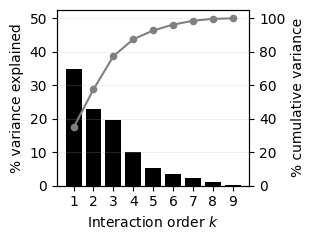

In [300]:
fig

### Evaluate model fit and predictions

In [302]:
inferred = pd.read_csv('data/inferred_vc_regression.csv', index_col=0)
data = pd.read_csv('data/dmsc_processed.csv', index_col=0)
test_pred = pd.read_csv('data/SD_test_pred.csv', index_col=0).join(data, rsuffix='_obs')
data = data.join(inferred, rsuffix='_pred')
data


,dmsC.1,dmsC.2,dmsC.3,n_measured,y,y_var,y_pred
Genotype,,,,,,,
AAAAAAAAA,0.256,0.769,0.664,3,0.563000,0.017082,0.563879
AAAAAAAAC,0.389,0.908,0.695,3,0.664000,0.017082,0.701486
AAAAAAAAG,0.417,0.830,0.682,3,0.643000,0.017082,0.619213
AAAAAAAAU,0.462,0.878,0.623,3,0.654333,0.017082,0.628787
AAAAAAACA,0.427,0.749,0.608,3,0.594667,0.017082,0.594647
...,...,...,...,...,...,...,...
UUUUUUUGU,0.400,0.762,0.955,3,0.705667,0.017082,0.615827
UUUUUUUUA,0.396,0.782,0.594,3,0.590667,0.017082,0.539003
UUUUUUUUC,0.311,0.698,0.645,3,0.551333,0.017082,0.548774


In [303]:
lims = (data['y'].min()-0.5, data['y'].max() + 0.5)
bins = np.linspace(lims[0], lims[-1], 100)

fig, axes = plt.subplots(1, 1, figsize=(3.25, 2.5), sharex=True, sharey=True)
x = data['y_pred']
y = data['y']
r2 = pearsonr(x, y)[0] ** 2
sns.histplot(x=x, y=y, cmap='viridis', ax=axes, bins=(bins, bins), 
             cbar=True, cbar_kws={'label': 'Number of sequences', 'shrink': 0.95})
axes.set(xlim=lims, ylim=lims, xticks=np.arange(4),
         xlabel='Training predicted log(GFP)', ylabel='Training measured log(GFP)')
axes.plot(lims, lims, lw=0.75, c='grey', linestyle='--')
axes.grid(alpha=0.2)
axes.text(0.05, 0.95, '$R^2$' + '={:.2f}'.format(r2),
          transform=axes.transAxes, va='top', ha='left')

fig.tight_layout()
fig.savefig('figures/vc_regression_fit.png', dpi=300)

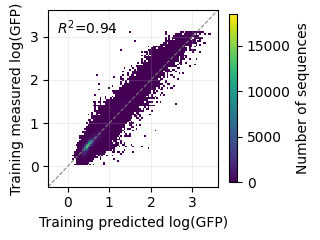

In [304]:
fig

In [305]:
test_pred

,y,y_var,std,ci_95_lower,ci_95_upper,dmsC.1,dmsC.2,dmsC.3,n_measured,y_obs,y_var_obs
AAAAGCUCG,0.500930,0.014568,0.120698,0.259534,0.742325,0.323,0.478,0.590,3,0.463667,0.017082
AAAAUUCGU,0.612574,0.015019,0.122554,0.367467,0.857682,NaN,0.654,0.628,2,0.641000,0.025624
AAAGGUAGU,1.427321,0.014791,0.121620,1.184080,1.670561,1.367,1.463,1.492,3,1.440667,0.017082
AAAGUAGAG,0.702300,0.014790,0.121615,0.459070,0.945529,0.418,0.956,0.585,3,0.653000,0.017082
AAAUCCAAA,0.513293,0.014599,0.120828,0.271637,0.754949,0.260,0.763,0.630,3,0.551000,0.017082
...,...,...,...,...,...,...,...,...,...,...,...
UUGGCUUAA,0.525195,0.014687,0.121192,0.282811,0.767578,NaN,0.592,0.584,2,0.588000,0.025624
UUGGGCGGC,0.512812,0.014883,0.121996,0.268819,0.756804,0.253,0.653,0.493,3,0.466333,0.017082
UUGGUGGUC,0.955759,0.015101,0.122885,0.709989,1.201528,1.277,1.381,NaN,2,1.329000,0.025624
UUUGAGGUG,1.800311,0.015138,0.123039,1.554233,2.046388,0.436,2.190,NaN,2,1.313000,0.025624


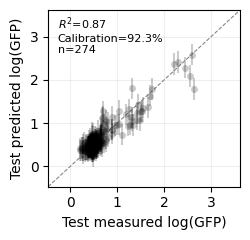

In [306]:
fig, axes = plt.subplots(1, 1, figsize=(2.6, 2.5), sharex=True, sharey=True)
x = test_pred['y_obs']
y = test_pred['y']
r2 = pearsonr(y, x)[0] ** 2
calibration = np.logical_and(test_pred['y_obs'] < test_pred['ci_95_upper'],
                             test_pred['y_obs'] > test_pred['ci_95_lower']).mean()
axes.errorbar(x, y, yerr=2 * test_pred['std'], #xerr=2 * np.sqrt(test_pred['y_var_obs']),
              color='black', fmt='o', alpha=0.2, markeredgewidth=0,
              markersize=5)
axes.set(xlim=lims, ylim=lims, xticks=np.arange(4),
         ylabel='Test predicted log(GFP)', xlabel='Test measured log(GFP)')
axes.plot(lims, lims, lw=0.75, c='grey', linestyle='--')
axes.grid(alpha=0.2)
axes.text(0.05, 0.97, '$R^2$' + '={:.2f}\nCalibration={:.1f}%\nn={}'.format(r2, calibration*100, test_pred.shape[0]),
          transform=axes.transAxes, va='top', ha='left', fontsize=8)

fig.tight_layout()
fig.savefig('figures/vc_regression_pred.svg')
fig

### Load models results

In [53]:
vcregression = pd.read_csv('data/inferred_vc_regression.csv', index_col=0)
seqdeft = pd.read_csv('data/seqdeft_inference.csv', index_col=0)

### Compute variance component statistics on inferred landscape

Variance explained by epistatic interactions is shown in the estimated variance components. Additive only up to 37%

But how is that distributed across sets of sites? Compute the marginal pairwise variance as the % variance explained by interactions of any order for every pair of sites

In [66]:
from gpmap.src.linop import calc_vjs_variance_components


def calc_variance_components(f):
    vc = defaultdict(lambda: 0)
    marginal_sites = {}
    marginal_pw = {}
    total_variance = np.sum((f - f.mean()) ** 2)
    for k in range(1, 10):
        m_j = 3**k
        vjs_k = defaultdict(lambda: 0)
        site_k = defaultdict(lambda: 0)
        vjs = calc_vjs_variance_components(f, a=4, l=9, k=k)

        for j, lambda_j in vjs.items():
            vc[k] += lambda_j * m_j / total_variance

            for site in j:
                site_k[site] += lambda_j * m_j / total_variance

            if k > 1:
                for a, b in combinations(j, 2):
                    vjs_k[(a, b)] += lambda_j * m_j / total_variance

        if k > 1:
            marginal_pw[k] = vjs_k
        marginal_sites[k] = site_k

    marginal_pw = pd.DataFrame(marginal_pw).reset_index()
    cols = list(range(2, 10))
    marginal_pw.columns = ["i", "j"] + cols
    marginal_pw["sum"] = marginal_pw[cols].sum(1)
    marginal_sites = pd.DataFrame(marginal_sites)
    vc = pd.DataFrame({'vc': pd.Series(vc)})

    return vc, marginal_sites, marginal_pw


In [79]:
vc, marginal_sites, marginal_pw = calc_variance_components(vcregression['y'])
vc.to_csv("data/vcregression.map_variance_components.csv")
marginal_pw.to_csv("data/vcregression.map_pairwise_marginal_epistasis.csv")
marginal_sites.to_csv("data/vcregression.map_site_marginal_epistasis.csv")

In [80]:
vc, marginal_sites, marginal_pw = calc_variance_components(np.log10(seqdeft["Q_star"]))
vc.to_csv("data/seqdeft.map_variance_components.csv")
marginal_pw.to_csv("data/seqdeft.map_pairwise_marginal_epistasis.csv")
marginal_sites.to_csv("data/seqdeft.map_site_marginal_epistasis.csv")

### Compare SeqDEFT against VC regression estimates in the complete genotype-phenotype map

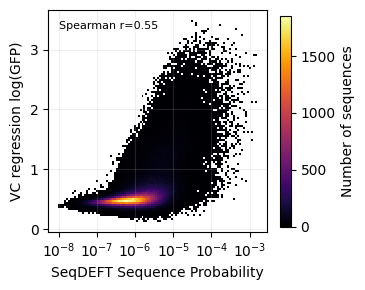

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(3.85, 3.), sharex=True, sharey=True)
x = np.log10(seqdeft['Q_star']).values
y = vcregression['y'].values
r = spearmanr(x, y)[0]
xticks = np.arange(-8, -2)
xticklabels = ['$10^{-8}$', '$10^{-7}$', '$10^{-6}$',
               '$10^{-5}$', '$10^{-4}$', '$10^{-3}$']
sns.histplot(x=x, y=y, cmap='inferno', ax=axes, bins=100, 
             cbar=True, cbar_kws={'label': 'Number of sequences', 'shrink': 0.95})
axes.set(ylabel='VC regression log(GFP)', xlabel='SeqDEFT Sequence Probability',
         xticks=xticks)
axes.set_xticklabels(xticklabels)
axes.grid(alpha=0.2)
axes.text(0.05, 0.95, 'Spearman r={:.2f}'.format(r),
          transform=axes.transAxes, va='top', ha='left', fontsize=8)

fig.tight_layout()
fig.savefig('figures/seqdeft_vs_vcregression.png', dpi=300)

In [81]:
threshold = 1e-4
df = vcregression.loc[seqdeft['Q_star'] > threshold, 'y']
print('Sequences with probability higher than {} have a mean of {:.2f} and std of {:.2}'.format(threshold, df.mean(), df.std()))

Sequences with probability higher than 0.0001 have a mean of 1.84 and std of 0.63


### Calculate visualizations coordinates for the inferred landscapes

In [85]:
# Load required data
vcregression = pd.read_csv('data/inferred_vc_regression.csv', index_col=0)
seqdeft = pd.read_csv('data/seqdeft_inference.csv', index_col=0)

In [86]:
# Calc SeqDEFT visualization
space = SequenceSpace(X=seqdeft.index.values, y=np.log(seqdeft['Q_star']))
rw = WMWalk(space)
rw.calc_visualization(Ns=1)
rw.write_tables(prefix='data/seqdeft', nodes_format='pq', edges_format='npz', write_edges=True)

In [311]:
# Calc VC regreesion visualization
space = SequenceSpace(X=vcregression.index.values, y=vcregression.y.values)
rw = WMWalk(space)
rw.calc_visualization(mean_function=2.5)
rw.write_tables(prefix='data/vcregression', nodes_format='pq', write_edges=False)

### Plot variance decomposition analysis

In [142]:
def plot_marginal_epistasis(axes, marginal_sites, vmax=20):
    pos_labels = [str(x) for x in range(-13, -4)]
    marginal_sites.index = pos_labels
    label = "% variance explained by\n interactions involving site $i$"
    sns.heatmap(
        marginal_sites * 100,
        ax=axes,
        cmap="Greys",
        cbar_kws={"label": label, 'shrink':0.8},
        vmax=vmax,
    )
    sns.despine(ax=axes, top=False, right=False)
    sns.despine(ax=fig.axes[-1], top=False, right=False)
    axes.set(
        xlabel="Order of interaction $k$", ylabel="Position $i$ relative to AUG"
    )
    axes.set_xticklabels(axes.get_xticklabels(), fontsize=9)
    axes.set_yticklabels(axes.get_yticklabels(), fontsize=9)


def plot_pairs_total_epistasis(axes, marginal_pw, vmax=20):
    pos_labels = [str(x) for x in range(-13, -4)]
    label = "% variance explained by\n interactions involving $i,j$"
    df = (
        pd.pivot_table(
            marginal_pw, index="i", columns="j", values="sum"
        ).fillna(0)
        * 100
    )
    m = np.zeros((9, 9))
    m[:-1, 1:] = df.values
    m[1:, :-1] += df.values.T
    df = pd.DataFrame(m, index=pos_labels, columns=pos_labels)

    sns.heatmap(df, ax=axes, cmap="Greys", cbar_kws={"label": label, 'shrink':0.8}, vmax=vmax)
    sns.despine(ax=axes, top=False, right=False)
    sns.despine(ax=fig.axes[-1], top=False, right=False)
    axes.set(
        xlabel="Position $i$ relative to AUG",
        ylabel="Position $j$ relative to AUG",
    )
    axes.set_xticklabels(axes.get_xticklabels(), fontsize=9)
    axes.set_yticklabels(axes.get_yticklabels(), fontsize=9)



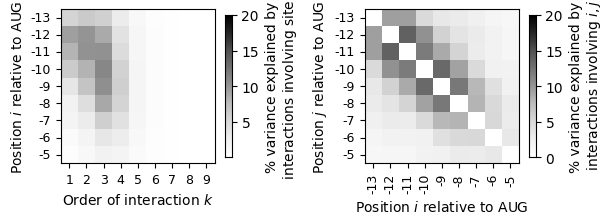

In [144]:

marginal_sites = pd.read_csv('data/vcregression.map_site_marginal_epistasis.csv', index_col=0)
marginal_pw = pd.read_csv('data/vcregression.map_pairwise_marginal_epistasis.csv', index_col=0)

fig, subplots = plt.subplots(1, 2, figsize=(2 * 3.1, 2.5))
plot_marginal_epistasis(subplots[0], marginal_sites)
plot_pairs_total_epistasis(subplots[1], marginal_pw)
for axes in subplots.flatten():
    axes.set(aspect="equal")
fig.tight_layout()
fig.savefig("figures/vcregression_site_marginal_epistasis.png", dpi=300)

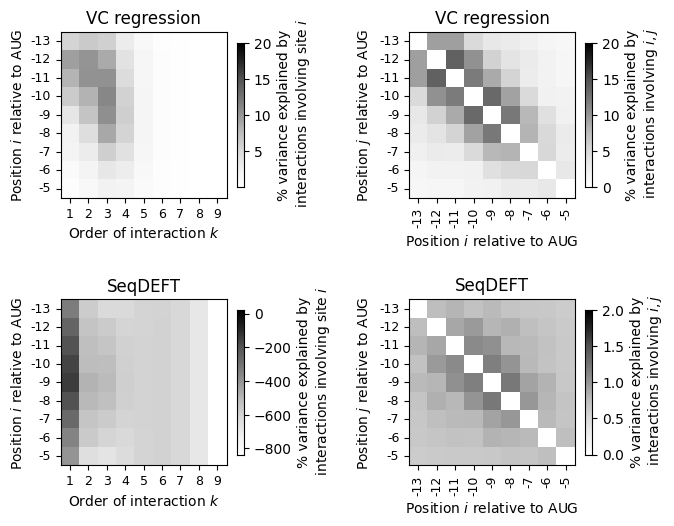

In [145]:
fig, subplots = plt.subplots(2, 2, figsize=(2 * 3.4, 2 * 2.75))

marginal_sites = pd.read_csv('data/vcregression.map_site_marginal_epistasis.csv', index_col=0)
marginal_pw = pd.read_csv('data/vcregression.map_pairwise_marginal_epistasis.csv', index_col=0)
plot_marginal_epistasis(subplots[0][0], marginal_sites)
plot_pairs_total_epistasis(subplots[0][1], marginal_pw)
subplots[0][0].set_title("VC regression")
subplots[0][1].set_title("VC regression")

marginal_sites = pd.read_csv('data/seqdeft.map_site_marginal_epistasis.csv', index_col=0)
marginal_pw = pd.read_csv('data/seqdeft.map_pairwise_marginal_epistasis.csv', index_col=0)
plot_marginal_epistasis(subplots[1][0], np.log(marginal_sites))
plot_pairs_total_epistasis(subplots[1][1], marginal_pw, vmax=2)
subplots[1][0].set_title('SeqDEFT')
subplots[1][1].set_title("SeqDEFT")

for axes in subplots.flatten():
    axes.set(aspect='equal')

fig.tight_layout(w_pad=2)
fig.savefig("figures/methods_site_marginal_epistasis.png", dpi=300)

### Load visualization

In [173]:
def plot_relaxation_times(relaxation_times):
    axes.scatter(
        relaxation_times["k"],
        relaxation_times["relaxation_time"],
        c="black",
        s=20,
    )
    axes.plot(
        relaxation_times["k"], relaxation_times["relaxation_time"], c="black", lw=1
    )
    axes.axhline(0.25, c="grey", lw=0.5, label="Neutral", linestyle="--")
    axes.legend(loc=1)
    axes.set(
        ylim=(0.1, 0.8),
        ylabel="Relaxation time\n(expected substitutions)",
        xlabel="Eigenvalue order $k$",
        xticks=relaxation_times["k"],
    )

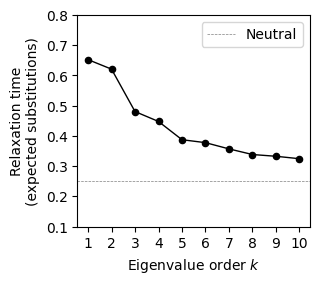

In [174]:
relaxation_times = pd.read_csv('data/seqdeft.decay_rates.csv')
fig, axes = plt.subplots(1, 1, figsize=(3, 2.75))
plot_relaxation_times(relaxation_times)
fig.savefig('figures/seqdeft_relaxation_times.png', dpi=300)

In [175]:
seqdeft_nodes_df = pd.read_parquet('data/seqdeft.nodes.pq')
vcreg_nodes_df = pd.read_parquet('data/vcregression.nodes.pq')
edges_df = read_edges('data/seqdeft.edges.npz')

In [176]:
peak1 = seqdeft_nodes_df.index[np.argmax(seqdeft_nodes_df['1'])]
peak2 = seqdeft_nodes_df.index[np.argmin(seqdeft_nodes_df['1'])]
peak3 = seqdeft_nodes_df.index[np.argmax(seqdeft_nodes_df['2'])]
peaks = [peak1, peak2, peak3]
peaks

['UUAAGGAGC', 'UAAGGAGCA', 'CAGGAGAAG']

### Visualize the landscape inferred with SeqDEFT

In [244]:
def annotate_seq(axes, seq, label, df, dx, dy, ha, va, x='1', y='2', fontsize=None):
    x, y = df.loc[seq, [x, y]]
    axes.annotate(label, xy=(x, y), xytext=(x + dx, y + dy),
                  arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6, headlength=10),
                  ha=ha, va=va, fontsize=fontsize)

def plot_path(axes, nodes, seqs, x='1', y='2', size=40):
    l = len(seqs)
    edf = pd.DataFrame({'i': np.arange(l-1), 
                        'j': np.arange(1, l)})
    ndf = nodes.loc[seqs, :]
    v = nodes['function']
    vmin, vmax = v.min(), v.max()
    plot.plot_nodes(axes, ndf, lw=1.5, size=size, cbar=False, vmin=-15,
                    vmax=vmax, color='function', zorder=4, x=x, y=y)
    plot.plot_edges(axes, ndf, edf, color='black', alpha=1, width=1.5, zorder=3, x=x, y=y)

In [191]:
def plot_landscape(axes, ndf, edf=None, title='', x='1', y='2', cmap_label='', vmin=np.log(1e-7),
                   vmax=np.log(1e-3), c='function', z='3'):
    
    bins = np.linspace(vmin, vmax, 30)
    nodes_hist_axes = axes.inset_axes((0.05, 0.875, 0.3, 0.1))
    nodes_hist_axes.patch.set_alpha(0)
    plot.plot_color_hist(nodes_hist_axes, ndf[c], cmap='viridis', bins=bins)
    nodes_cbar_axes = axes.inset_axes((0.05, 0.85, 0.3, 0.02))

    plot.plot_nodes(axes, ndf, x=x, y=y, 
                    sort_by=z, sort_ascending=True, 
                    color=c, size=5, cmap='viridis',
                    cbar_axes=nodes_cbar_axes,
                    cbar_label=cmap_label,
                    cbar_orientation='horizontal',
                    vmin=vmin, vmax=vmax)
    if edf is not None:
        plot.plot_edges(axes, ndf, edf, x=x, y=y, alpha=0.05)
        
    nodes_cbar_axes.set_xlabel('Sequence probability', fontsize=12)
    nodes_hist_axes.set_ylabel('Frequency', fontsize=12)
    yticklabels = 10 ** np.arange(-7, -2).astype(float)
    nodes_cbar_axes.set_xticks(np.log(yticklabels))
    nodes_cbar_axes.set_xticklabels(['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'])
    
    axes.set_title(title, fontsize=16)
    axes.set(aspect='equal', xlabel='', ylabel='')
    axes.spines['left'].set(position=('data', 0), zorder=0,alpha=0.5)
    axes.spines['bottom'].set(position=('data', 0), zorder=0, alpha=0.5)
    axes.grid(alpha=0.2)
    ticks = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
    axes.set(xticks=ticks, yticks=ticks, ylim=(-3.1, 3.1), xlim=(-3.1, 3.1))
    axes.plot((1), (0), ls="", marker=">", ms=5, color="k",
              transform=axes.get_yaxis_transform(), clip_on=False)
    axes.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=axes.get_xaxis_transform(), clip_on=False)
    axes.annotate('Diffusion axis {}'.format(x), xy=(0.9, -0.4), xycoords=('axes fraction', 'data'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='top')
    axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='bottom')
    sns.despine(ax=axes)



/tmp/ipykernel_204273/1955737307.py:37: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(x), xy=(0.9, -0.35), xycoords=('axes fraction', 'data'),
/tmp/ipykernel_204273/1955737307.py:40: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'),


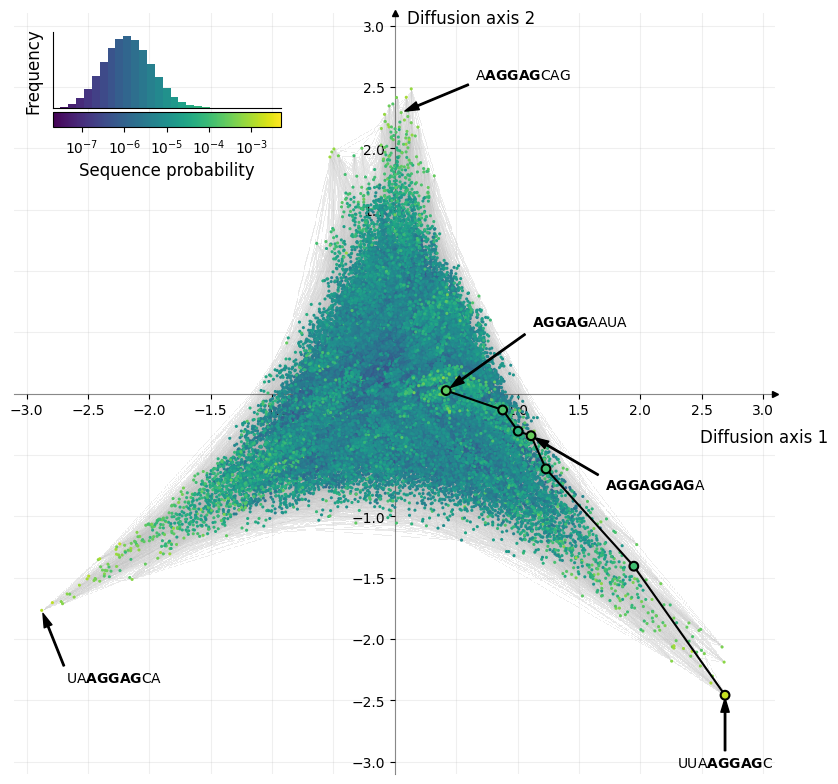

In [179]:
#fig, axes = plt.subplots(1, 1, figsize=(11, 10))
dsg = dplot.plot_edges(seqdeft_nodes_df, edges_df=edges_df, resolution=800)
fig = dplot.dsg_to_fig(dsg)
fig.set_size_inches((8.5, 8))
axes = fig.axes[0]

plot_landscape(axes, seqdeft_nodes_df, #edf=edges_df,
               x='1', y='2', title = '', vmax=np.log(5e-3), vmin=np.log(2e-8),
               cmap_label='log(P)')
axes.set(aspect='equal')
annotate_seq(axes, 'AAGGAGCAG', r'A$\bf{AGGAG}$CAG', seqdeft_nodes_df,
             dx=0.6, dy=0.25, ha='left', va='bottom')
annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', seqdeft_nodes_df,
             dx=0, dy=-0.5, ha='center', va='top')
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', seqdeft_nodes_df,
             dx=0.2, dy=-0.5, ha='left', va='top')
seqs = ['AGGAGAAUA', 'AGGAGGAUA', 'AGGAGGAGA',
        'AGGAGGAGC',
        'UGGAGGAGC', 'UUGAGGAGC', 'UUAAGGAGC',
       ]
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', seqdeft_nodes_df,
             dx=0.7, dy=0.5, ha='left', va='bottom')
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$A', seqdeft_nodes_df,
             dx=0.6, dy=-0.35, ha='left', va='top')


plot_path(axes, seqdeft_nodes_df, seqs)
fig.tight_layout()
fig

In [368]:
fig.savefig('figures/seqdeft_visualization.png', dpi=300)

In [277]:
fig, subplots = plt.subplots(1, 4, figsize=(12, 3.5),
                             gridspec_kw={'width_ratios': [1, 1, 1, 0.035]})
nodes_cbar_axes = subplots[-1]

diffusion_axes = [
    ("1", "2", "3"), 
    ("1", "3", "2"),
    ("2", "3", "1"),
]

for axes, (x, y, z) in zip(subplots[:3], diffusion_axes):
    plot.plot_edges(axes, seqdeft_nodes_df, edges_df=edges_df,
                    x=x, y=y, alpha=0.02)
    plot.plot_nodes(axes, seqdeft_nodes_df, x=x, y=y, 
                    sort_by=z, sort_ascending=True, 
                    color='function', size=5, cmap='viridis',
                    cbar_axes=nodes_cbar_axes,
                    cbar_orientation='vertical',
                    vmax=np.log(5e-3), vmin=np.log(2e-8))
    yticklabels = 10 ** np.arange(-7, -2).astype(float)
    nodes_cbar_axes.set_ylabel('Sequence probability', fontsize=9)
    nodes_cbar_axes.set_yticks(np.log(yticklabels))
    nodes_cbar_axes.set_yticklabels(['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'])

    axes.set(aspect='equal', xlabel='', ylabel='',
             ylim=(-3.1, 3.1), xlim=(-3.1, 3.1))
    axes.spines['left'].set(position=('data', 0), zorder=0,alpha=0.5)
    axes.spines['bottom'].set(position=('data', 0), zorder=0, alpha=0.5)
    axes.plot((1), (0), ls="", marker=">", ms=5, color="k",
                transform=axes.get_yaxis_transform(), clip_on=False)
    axes.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=axes.get_xaxis_transform(), clip_on=False)
    axes.text(1, 0.42, 'Diffusion\naxis {}'.format(x), 
            transform=axes.transAxes, fontsize=9, ha='center', va='top')
    axes.text(0.625, 0.98, 'Diffusion\naxis {}'.format(y), 
            transform=axes.transAxes, fontsize=9, ha='center', va='top')
    axes.tick_params(labelsize=8)
    sns.despine(ax=axes)


    axes.set(aspect='equal')
    seqs = ['AGGAGAAUA', 'AGGAGGAUA', 'AGGAGGAGA',
            'AGGAGGAGC',
            'UGGAGGAGC', 'UUGAGGAGC', 'UUAAGGAGC']
    plot_path(axes, seqdeft_nodes_df, seqs, x=x, y=y, size=30)

fontsize = 8
axes = subplots[0]
x, y, z = ("1", "2", "3")
axes.set(aspect='equal')
annotate_seq(axes, 'AAGGAGCAG', r'A$\bf{AGGAG}$CAG', seqdeft_nodes_df,
             dx=0.6, dy=-0.35, ha='left', va='top', fontsize=fontsize)
annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', seqdeft_nodes_df,
             dx=0, dy=-0.5, ha='center', va='top', fontsize=fontsize)
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', seqdeft_nodes_df,
             dx=0.2, dy=-0.5, ha='left', va='top', fontsize=fontsize)
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', seqdeft_nodes_df,
             dx=0.7, dy=0.5, ha='left', va='bottom', fontsize=fontsize)
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$C', seqdeft_nodes_df,
             dx=0.6, dy=0.7, ha='left', va='top', fontsize=fontsize)

axes = subplots[1]
x, y, z = ("1", "3", "2")
annotate_seq(axes, 'AAGGAGCAG', r'A$\bf{AGGAG}$CAG', seqdeft_nodes_df,
        dx=0.2, dy=-0.9, ha='left', va='bottom', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', seqdeft_nodes_df,
        dx=0, dy=-0.5, ha='center', va='top', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', seqdeft_nodes_df,
        dx=0.2, dy=-0.5, ha='left', va='top', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', seqdeft_nodes_df,
        dx=0.7, dy=0.5, ha='left', va='bottom', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$C', seqdeft_nodes_df,
        dx=0.6, dy=0.35, ha='left', va='top', x=x, y=y, fontsize=fontsize)

axes = subplots[2]
x, y, z = ("2", "3", "1")
annotate_seq(axes, 'AAGGAGCAG', r'A$\bf{AGGAG}$CAG', seqdeft_nodes_df,
        dx=0.2, dy=-0.9, ha='center', va='bottom', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', seqdeft_nodes_df,
        dx=0, dy=-0.5, ha='center', va='top', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', seqdeft_nodes_df,
        dx=-0.3, dy=0.2, ha='right', va='bottom', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', seqdeft_nodes_df,
        dx=0.7, dy=0.3, ha='left', va='bottom', x=x, y=y, fontsize=fontsize)
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$C', seqdeft_nodes_df,
        dx=-0.6, dy=0.45, ha='right', va='bottom', x=x, y=y, fontsize=fontsize)

fig.tight_layout()
nodes_cbar_axes.set_position([0.9, 0.2, 0.0075, 0.6])

fig.savefig('figures/seqdeft.visualization.axis3.png', dpi=300)
fig

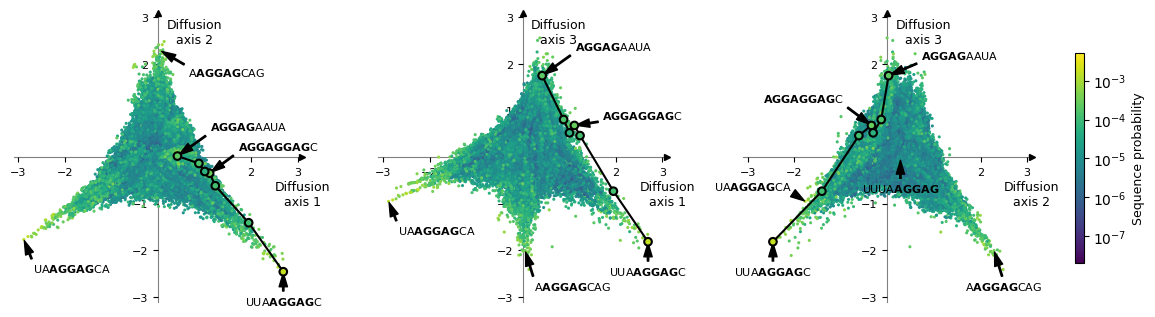

In [276]:
fig

### Compute mutational effects in different genetic backgrounds

In [69]:
def get_single_mutants(seq, ndf):
    seqs = []
    for p in range(len(seq)):
        for a in 'ACGU':
            s = [c for c in seq]
            s[p] = a
            seqs.append(''.join(s))
    df = pd.DataFrame(ndf.loc[seqs, 'function'].values.reshape((9, 4)),
                      columns=['A', 'C', 'G', 'U'],
                      index=np.arange(-13, -4))
    return(df)

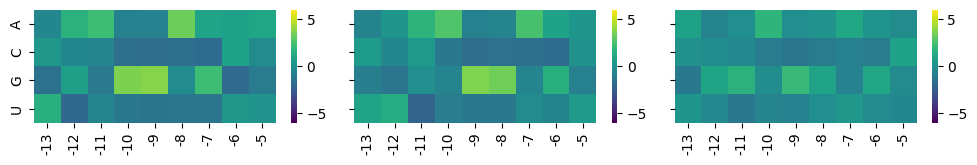

In [74]:
fig, subplots = plt.subplots(1, 3, figsize=(10, 1.75), sharex=True, sharey=True)

seqs = ['AAGGAGCAG', 'UUAAGGAGC', 'AGGAGGAGC']

for seq, axes in zip(seqs, subplots):
    df = get_single_mutants(seq, seqdeft_nodes_df)#.T - seqdeft_nodes_df.loc[seq, 'function']
    df = (df.T - df.T.mean(0))
    sns.heatmap(df, ax=axes, cmap='viridis', vmin=-6, vmax=6)
    #axes.set(xticks=df.index.values, xlabel='Position relative to AUG', ylim=(-4, 4))
    #axes.axhline(0, lw=1, c='black')

#subplots[0].set(ylabel='Allelic contribution')
fig.tight_layout()

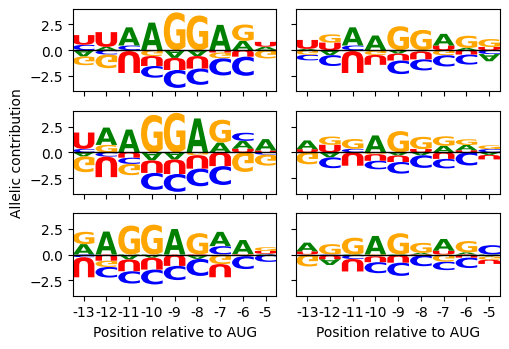

In [101]:
seqs = ['UUAAGGAGC', 'UAAGGAGCA', 'AAGGAGCAG', 
        'UUGAGGAGC', 'UGGAGGAGC', 'AGGAGGAGC']
nplots = len(seqs)
fig, subplots = plt.subplots(3, 2, figsize=(2 * 2.6, 3 * 1.2), sharex=True, sharey=True)
subplots = subplots.T.flatten()

for seq, axes in zip(seqs, subplots):
    df = get_single_mutants(seq, seqdeft_nodes_df)
    df = (df.T - df.T.mean(0)).T
    logomaker.Logo(df, ax=axes)
    axes.set(xticks=df.index.values, ylim=(-4, 4),
             ylabel='',
             xticklabels=[],
             #title='{} background'.format(seq)
            )
    axes.axhline(0, lw=1, c='black')

subplots[-1].set(xlabel='Position relative to AUG', xticklabels=df.index.values)
subplots[2].set(xlabel='Position relative to AUG')
subplots[1].set(ylabel='Allelic contribution')
fig.tight_layout()

In [176]:
backgrounds = ['UUAAGGAGC', 'UAAGGAGCA', 'AAGGAGCAG']

positions = np.arange(-13, -4)
contrasts = {}

for bc1, bc2 in combinations(backgrounds, 2):
    for p, (pos, a1, a2) in enumerate(zip(positions, bc1, bc2)):
        if a1 == a2:
            continue
        label = '{}{}{}'.format(a1, pos, a2)
    
        for bc in [bc1, bc2]:
            s = [c for c in bc]
            s[p] = a1
            s1 = ''.join(s)
            s[p] = a2
            s2 = ''.join(s)
            contrasts['{}_in_{}'.format(label, bc)] = {s1: -1, s2: 1}
contrasts_matrix = pd.DataFrame(contrasts).fillna(0)
contrasts_matrix


,U-12A_in_UUAAGGAGC,U-12A_in_UAAGGAGCA,A-10G_in_UUAAGGAGC,A-10G_in_UAAGGAGCA,G-8A_in_UUAAGGAGC,G-8A_in_UAAGGAGCA,A-7G_in_UUAAGGAGC,A-7G_in_UAAGGAGCA,G-6C_in_UUAAGGAGC,G-6C_in_UAAGGAGCA,C-5A_in_UUAAGGAGC,C-5A_in_UAAGGAGCA
UUAAGGAGC,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0
UAAAGGAGC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UUAGGAGCA,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAAGGAGCA,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
UUAGGGAGC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAAAGAGCA,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UUAAGAAGC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAAGGGGCA,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
UUAAGGGGC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
UAAGGAACA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0


In [177]:
peaks_contrasts = model.make_contrasts(contrasts_matrix)
peaks_contrasts['mutation'] = [x.split('_')[0] for x in peaks_contrasts.index.values]
peaks_contrasts['background'] = [x.split('_')[-1] for x in peaks_contrasts.index.values]
peaks_contrasts.to_csv('data/peaks_contrasts.csv')
peaks_contrasts

,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
U-12A_in_UUAAGGAGC,0.036345,0.120603,-0.204860,0.277550,0.618430
U-12A_in_UAAGGAGCA,0.439020,0.120576,0.197868,0.680171,0.999864
A-10G_in_UUAAGGAGC,-1.296351,0.125056,-1.546463,-1.046240,1.000000
A-10G_in_UAAGGAGCA,1.868438,0.124346,1.619746,2.117130,1.000000
G-8A_in_UUAAGGAGC,-1.635447,0.124599,-1.884646,-1.386249,1.000000
G-8A_in_UAAGGAGCA,1.837405,0.120471,1.596464,2.078347,1.000000
A-7G_in_UUAAGGAGC,-1.434498,0.120735,-1.675968,-1.193027,1.000000
A-7G_in_UAAGGAGCA,0.767008,0.130634,0.505740,1.028275,1.000000
G-6C_in_UUAAGGAGC,-1.465288,0.124660,-1.714608,-1.215968,1.000000
G-6C_in_UAAGGAGCA,-0.602366,0.139946,-0.882259,-0.322474,0.999992


In [149]:
seqs = ['AGGAGGUAA',
        'AGGAGGAGG',
        'UUAAGGUAA',
        'UUAAGGAGG']
pred = model.predict(seqs, calc_variance=True)
pred.to_csv('data/path_contrasts.csv')
pred

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.50s/it]


,y,y_var,std,ci_95_lower,ci_95_upper
AGGAGGUAA,2.920414,0.012360,0.111173,2.698067,3.142761
AGGAGGAGG,3.274419,0.012731,0.112830,3.048759,3.500079
UUAAGGUAA,1.579406,0.008220,0.090667,1.398072,1.760739
UUAAGGAGG,2.992375,0.012282,0.110826,2.770724,3.214026


In [171]:
contrast_matrix = pd.DataFrame({'coef': [1, -1, -1, 1]}, index=seqs)
contrast_matrix

,coef
AGGAGGUAA,1
AGGAGGAGG,-1
UUAAGGUAA,-1
UUAAGGAGG,1


In [172]:
c = model.make_contrasts(contrast_matrix)
c

,estimate,std,ci_95_lower,ci_95_upper,p(|x|>0)
coef,1.058964,0.185569,0.687826,1.430103,1.0


/tmp/ipykernel_453000/1189398667.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = np.arange(df.shape[0])
/tmp/ipykernel_453000/1189398667.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = np.arange(df.shape[0])


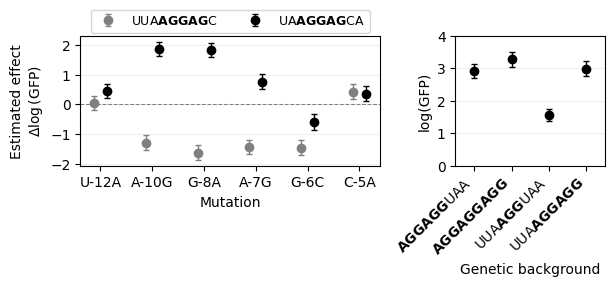

In [228]:
fig, subplots = plt.subplots(1, 2, figsize=(6.25, 3), width_ratios=[2, 1])

axes = subplots[0]
df = peaks_contrasts.loc[peaks_contrasts['background'] == 'UUAAGGAGC', :]
df['x'] = np.arange(df.shape[0])
axes.errorbar(df['x']-0.125, df['estimate'], yerr=2 * df['std'],
              fmt='o', lw=0, elinewidth=1, capsize=2.5, color='grey',
              label=r'UUA$\bf{AGGAG}$C')

df = peaks_contrasts.loc[peaks_contrasts['background'] == 'UAAGGAGCA', :]
df['x'] = np.arange(df.shape[0])
axes.errorbar(df['x']+0.125, df['estimate'], yerr=2 * df['std'],
              fmt='o', lw=0, elinewidth=1, capsize=2.5, color='black',
              label=r'UA$\bf{AGGAG}$CA')

axes.set(xlabel='Mutation', ylabel='Estimated effect\n$\Delta\log$(GFP)',
         xticks=df['x'],
         yticks=[-2, -1, 0, 1, 2],
         xticklabels=df['mutation'])
axes.axhline(0, linestyle='--', c='grey', lw=0.75)
axes.legend(loc=(0.035, 1.025), ncol=2, fontsize=9)
axes.grid(alpha=0.2, axis='y')

# Path posterior
pred['step'] = np.arange(1, pred.shape[0]+1)
axes = subplots[1]
axes.errorbar(pred['step'], pred['y'], yerr=2 * pred['std'],
              fmt='o', lw=0, elinewidth=1, capsize=2.5, color='black')

axes.set(xlabel='Genetic background', xticks=pred['step'],
         ylabel='log(GFP)',
         ylim=(0, 4.), xlim=(0.5, 4.5))
labels = [r'$\bf{AGGAGG}$UAA', r'$\bf{AGGAGGAGG}$', r'UUA$\bf{AGG}$UAA', r'UUA$\bf{AGGAGG}$']
axes.set_xticklabels(labels, rotation=45, ha='right')
axes.grid(alpha=0.2, axis='y')
fig.tight_layout()
fig.savefig('figures/path_posterior.svg', dpi=300)

### Visualizing the landscape inferred with VC regression 

In [317]:
vcreg_nodes_df = pd.read_parquet('data/vcregression.nodes.pq')
edges_df = read_edges('data/seqdeft.edges.npz')

In [318]:
td_nodes_df['function'].min(), td_nodes_df['function'].max()

(0.1190274581313133, 3.494399096816778)

In [376]:
def plot_landscape(axes, ndf, edf=None, title='', x='1', y='2', cmap_label='', vmin=0,
                   vmax=3.5, c='function'):
    
    bins = np.linspace(vmin, vmax, 30)
    nodes_hist_axes = axes.inset_axes((0.75, 0.875, 0.3, 0.1))
    nodes_hist_axes.patch.set_alpha(0)
    plot.plot_color_hist(nodes_hist_axes, ndf[c], cmap='viridis', bins=bins)
    nodes_cbar_axes = axes.inset_axes((0.75, 0.85, 0.3, 0.02))

    plot.plot_nodes(axes, ndf, x=x, y=y, 
                    sort_by='3', sort_ascending=True, 
                    color=c, size=5, cmap='viridis',
                    cbar_axes=nodes_cbar_axes,
                    cbar_label=cmap_label,
                    cbar_orientation='horizontal',
                    vmin=vmin, vmax=vmax)
    if edf is not None:
        plot.plot_edges(axes, ndf, edf, x=x, y=y, alpha=0.05)
        
    nodes_cbar_axes.set_xlabel('log(GFP)', fontsize=12)
    nodes_hist_axes.set_ylabel('Frequency', fontsize=12)
    #yticklabels = 10 ** np.arange(-7, -3).astype(float)
    #nodes_cbar_axes.set_xticks(np.log(yticklabels))
    #nodes_cbar_axes.set_xticklabels(['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$'])
    
    axes.set_title(title, fontsize=16)
    axes.set(aspect='equal', xlabel='', ylabel='')
    axes.spines['left'].set(position=('data', 0), zorder=0,alpha=0.5)
    axes.spines['bottom'].set(position=('data', 0), zorder=0, alpha=0.5)
    axes.grid(alpha=0.2)
    #ticks = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
    #axes.set(xticks=ticks, yticks=ticks, ylim=(-3, 3.5), xlim=(-3, 4.5))
    axes.plot((1), (0), ls="", marker=">", ms=5, color="k",
              transform=axes.get_yaxis_transform(), clip_on=False)
    axes.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=axes.get_xaxis_transform(), clip_on=False)
    axes.annotate('Diffusion axis {}'.format(x), xy=(0.9, 0.35), xycoords=('axes fraction', 'data'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='center')
    axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='bottom')
    sns.despine(ax=axes)



/home/martigo/miniforge3/envs/gpmap/lib/python3.8/site-packages/holoviews/plotting/mpl/plot.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
/home/martigo/miniforge3/envs/gpmap/lib/python3.8/site-packages/holoviews/plotting/mpl/plot.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
/tmp/ipykernel_295196/764756712.py:37: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead

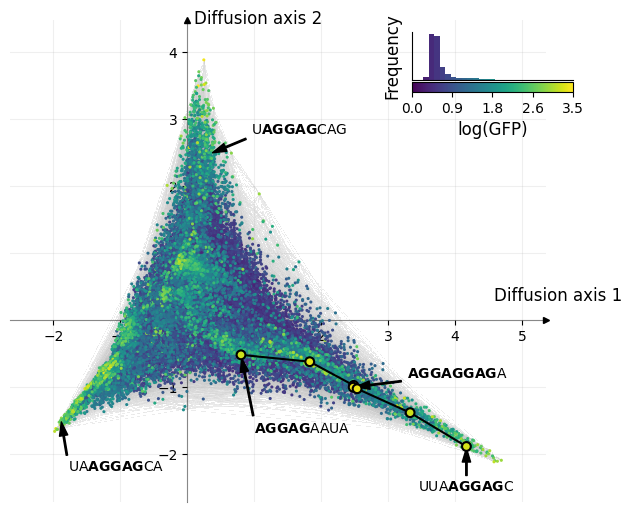

In [380]:
# fig, axes = plt.subplots(1, 1, figsize=(7.5, 7.5))
dsg = dplot.plot_edges(td_nodes_df, edges_df=edges_df, resolution=800).opts(padding=0.1)

fig = dplot.dsg_to_fig(dsg)
fig.set_size_inches((6.5, 6))
axes = fig.axes[0]

plot_landscape(axes, vcreg_nodes_df, #edf=edges_df,
               cmap_label='log(GFP)')

axes.set(aspect='equal')

annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', vcreg_nodes_df,
             dx=0, dy=-0.5, ha='center', va='top')
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', vcreg_nodes_df,
             dx=0.1, dy=-0.6, ha='left', va='top')
annotate_seq(axes, 'AAGGAGCAG', r'U$\bf{AGGAG}$CAG', vcreg_nodes_df,
             dx=0.6, dy=0.25, ha='left', va='bottom')

seqs = ['AGGAGAAUA', 'AGGAGGAUA', 'AGGAGGAGA',
        'AGGAGGAGC',
        'UGGAGGAGC', 'UUGAGGAGC', 'UUAAGGAGC',
       ]
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', vcreg_nodes_df,
             dx=0.2, dy=-1.0, ha='left', va='top')
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$A', vcreg_nodes_df,
             dx=0.8, dy=0.1, ha='left', va='bottom')


plot_path(axes, vcreg_nodes_df, seqs)


fig.tight_layout()
fig

In [381]:
fig.savefig('figures/vc_visualization.png', dpi=300)

### Fit thermodynamic model

In [337]:
class ThermodynamicModel(torch.nn.Module):
    def __init__(self, seq0='AGGAGGUA'):
        super().__init__()
        self.seq0 = seq0
        self.l = len(seq0)
        self.upstream_seq = 'CCG'
        self.downstream_seq = 'UGAG'
        self.npos = len(self.upstream_seq) + len(self.downstream_seq) + 9 - self.l
        
    def seqs_to_x(self, seqs):
        x = np.array([[c for c in s] for s in seqs])
        X = torch.tensor(np.stack([x == c for c in 'ACGU'], axis=2)).to(dtype=torch.float32)
        # x = np.array([[[c == a for a in 'ACGU' if a != ref]
        #                for c, ref in zip(s, self.seq0)]
        #               for s in seqs])
        # X = torch.tensor(x).to(dtype=torch.float32)
        return(X)

    def encode_seqs(self, seqs):
        extended_seqs = [[(self.upstream_seq + seq + self.downstream_seq)[i:i + self.l] for seq in seqs]
                         for i in range(self.npos)]
        X = torch.stack([self.seqs_to_x(s) for s in extended_seqs], axis=3)
        return(X)
        
    def init_params(self):
        # theta_raw0 = self.seqs_to_x([self.seq0])[0]
        # self.theta_raw = torch.nn.Parameter(theta_raw0)
        self.theta_raw = torch.nn.Parameter(torch.normal(torch.zeros((self.l, 4))))
        self.theta0 = torch.nn.Parameter(torch.zeros(1, self.npos))
        self.background = torch.nn.Parameter(torch.zeros(1,))
        self.max_value = torch.nn.Parameter(torch.ones(1,))
        self.log_sigma2 = torch.nn.Parameter(torch.zeros(1,))

    @property
    def theta(self):
        return(self.theta_raw - self.theta_raw.mean(1).unsqueeze(1))
        # return(self.theta_raw)

    @property
    def sigma2(self):
        return(torch.exp(self.log_sigma2))
    
    def summary(self, pred=None, obs=None):
        print('===========================')
        print('Log-likelihood = {:.2f}'.format(model.history[-1]))
        print('======= Parameters ========')
        for param, values in self.get_params().items():
            print('--- {} ---'.format(param))
            print(values)

        if pred is not None and obs is not None:
            r = pearsonr(pred, obs)[0]
            print('======= Predictions ========')
            print('Pearson r = {:.2f}'.format(r))        
       
    def predict(self, X):
        phi = self.theta0 + torch.tensordot(X, self.theta, dims=((1, 2), (0, 1)))
        mu = torch.exp(-phi).sum(axis=1)
        p = mu / (1 + mu)
        yhat = self.background + self.max_value * p
        return(yhat)
    
    def fit(self, seqs, y, y_var, n_iter=1000, lr=0.1):
        X = self.encode_seqs(seqs)
        y = torch.Tensor(y)
        y_var = torch.Tensor(y_var)
        
        self.init_params()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        history = []
        for i in tqdm(range(n_iter)):
            optimizer.zero_grad()
            yhat = self.predict(X)
            loss = torch.nn.functional.gaussian_nll_loss(yhat, y, y_var + self.sigma2, reduction='mean')
            loss.backward()
            history.append(loss.detach().item())
            optimizer.step()
        self.history = history
    
    def get_params(self):
        params = {
                  'theta0': self.theta0.detach().numpy()[0],
                  'theta': pd.DataFrame(self.theta.detach().numpy(), columns=['A', 'C', 'G', 'U']),
                  'background': self.background.detach().numpy()[0],
                  'max_value': self.max_value.detach().numpy()[0],
                  'sigma2': self.sigma2.detach().numpy()[0],
                  }
        return(params)    

In [338]:
idx = np.random.uniform(size=X_train.shape[0]) < 0.2

In [339]:
model = ThermodynamicModel(seq0='AGGAGGUA')
# model.fit(X_train, y_train, y_var_train, n_iter=2500, lr=0.005)
model.fit(X_train[idx], y_train[idx], y_var_train[idx], n_iter=2500, lr=0.01)

100%|██████████| 2500/2500 [00:32<00:00, 78.01it/s]


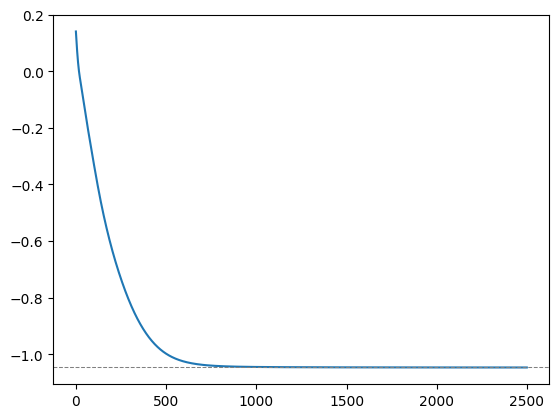

In [340]:
fig, axes = plt.subplots(1, 1)
axes.plot(model.history)
axes.axhline(model.history[-1], linestyle='--', c='grey', lw=0.75)
fig

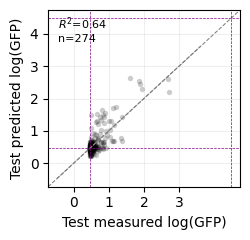

In [341]:
background = model.background.detach().numpy()[0]
max_value = model.max_value.detach().numpy()[0]

lims = (data['y'].min()-0.5, data['y'].max() + 0.5)
fig, axes = plt.subplots(1, 1, figsize=(2.6, 2.5), sharex=True, sharey=True)
x = model.predict(model.encode_seqs(X_test)).detach().numpy()
y = y_test
r2 = pearsonr(y, x)[0] ** 2
axes.scatter(x, y,  color='black', alpha=0.2, lw=0, s=15)
axes.set(#xlim=lims, ylim=lims, 
         xticks=np.arange(4),
         ylabel='Test predicted log(GFP)', xlabel='Test measured log(GFP)')
sigma = np.sqrt(model.sigma2.detach().numpy()[0])
axes.plot(lims, lims, lw=0.75, c='grey', linestyle='--')
axes.axline((0, 0), (1, 1), lw=0.75, c='grey', linestyle='--')

axes.axhline(background, lw=0.5, c='purple', linestyle='--')
axes.axhline(background + max_value, lw=0.5, c='purple', linestyle='--')
axes.axvline(background, lw=0.5, c='purple', linestyle='--')
axes.axvline(background + max_value, lw=0.5, c='purple', linestyle='--')


# plt.axline((0, 2 * sigma), (1, 1 + 2 * sigma), lw=0.5, c='grey', linestyle='--')
# plt.axline((0, -2 * sigma), (1, 1 - 2 * sigma), lw=0.5, c='grey', linestyle='--')

axes.grid(alpha=0.2)
axes.text(0.05, 0.97, '$R^2$' + '={:.2f}\nn={}'.format(r2, y.shape[0]),
          transform=axes.transAxes, va='top', ha='left', fontsize=8)

fig.tight_layout()
fig.savefig('figures/thermodynamic_model_pred.svg')
background, background + max_value
fig

In [342]:
model.summary(x, y_test)

Log-likelihood = -1.05
======= Parameters ========
--- theta0 ---
[ 7.805303   8.4657135  8.656613   8.8309965  8.7967615  9.051311
  9.676983  11.812621 ]
--- theta ---
          A         C         G         U
0 -0.539526  0.768763 -0.266702  0.037464
1  0.091926  0.878986 -1.263222  0.292310
2 -0.074444  2.418589 -2.470454  0.126309
3 -1.467044  1.248707 -0.223242  0.441579
4 -0.812104  3.754349 -2.500085 -0.442159
5 -0.084526  0.657146 -0.530621 -0.042000
6 -0.238155  0.381846  0.155571 -0.299262
7 -0.472833  0.444639  0.105602 -0.077409
--- background ---
0.46657026
--- max_value ---
4.0188007
--- sigma2 ---
0.01820484
======= Predictions ========
Pearson r = 0.80


In [343]:
T = 273 + 37
RT = 0.592 / 298 * T
m = pd.DataFrame(RT * model.theta[:, :].detach(), columns=[x for x in 'ACGU'])
theta0 = RT * model.theta0.detach().numpy()
m.to_csv('data/thermodynamic_model.theta.csv')

In [344]:
mut_A4U = m.loc[3, 'G'] - m.loc[3, 'A']
mut_A4C = m.loc[3, 'C'] - m.loc[3, 'A']
print('Mut effects\n\tA4G = {:.2} (kcal/mol)\n\tA4C = {:.2f}'.format(mut_A4U, mut_A4C))

Mut effects
	A4G = 0.77 (kcal/mol)
	A4C = 1.67


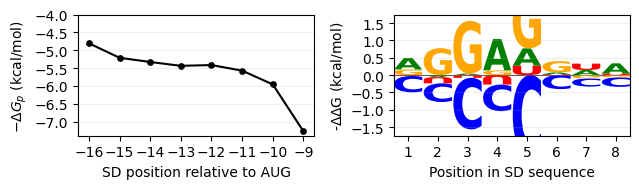

In [345]:
fig, subplots = plt.subplots(1, 2, figsize=(3.25 * 2, 2.))

axes = subplots[0]
positions = np.arange(-16, -16 + model.npos)
axes.scatter(positions, -theta0[0], c='black', s=15)
axes.plot(positions, -theta0[0], c='black')
axes.set(xlabel='SD position relative to AUG',
         xticks=positions,
         ylabel='$-\Delta G_p$ (kcal/mol)',
         yticks=np.linspace(-7, -4, 7))
axes.grid(alpha=0.2, axis='y')

axes = subplots[1]
logomaker.Logo(-m, ax=axes)
axes.set(ylabel=r'-$\Delta\Delta$G (kcal/mol)',
         yticks=[-1.5, -1, -0.5, 0, 0.5, 1, 1.5],
         ylim=(-1.75, 1.75),
         xlabel='Position in SD sequence',
         xticks=np.arange(0, m.shape[0]),
         xticklabels=np.arange(0, m.shape[0]) + 1)
axes.grid(alpha=0.2, axis='y')
fig.tight_layout()
fig.savefig('figures/energy_logo.svg', dpi=300)
fig

### Predict complete landscape and compute visualization

In [146]:
seqs = [''.join(c) for c in product('ACGU', repeat=9)]
X_full = model.encode_seqs(seqs)
y_pred = pd.DataFrame({'y_pred': model.predict(X_full).detach()}, index=seqs)
phi = pd.DataFrame((model.theta0 + torch.tensordot(X_full, model.theta, dims=((1, 2), (0, 1)))).detach().numpy(), 
                   columns=['dg{}'.format(i+1) for i in range(8)], index=seqs)
y_pred = y_pred.join(phi)
y_pred


,y_pred,dg1,dg2,dg3,dg4,dg5,dg6,dg7,dg8
AAAAAAAAA,0.636931,3.788378,4.766278,5.249426,5.186042,5.210475,5.852650,6.579613,8.360197
AAAAAAAAC,0.619047,3.788378,4.766278,5.249426,5.186042,6.177978,6.483018,7.347788,11.437141
AAAAAAAAG,0.631512,3.788378,4.766278,5.249426,5.186042,5.846937,6.303559,6.138481,6.611642
AAAAAAAAU,0.631173,3.788378,4.766278,5.249426,5.186042,5.648092,5.794033,6.582975,8.741693
AAAAAAACA,0.608243,3.788378,4.766278,5.249426,6.153544,5.840843,6.620825,9.656558,11.235077
...,...,...,...,...,...,...,...,...,...
UUUUUUUGU,0.476885,6.530846,7.578737,8.258602,9.030107,9.365222,8.615760,7.715782,10.920831
UUUUUUUUA,0.475828,6.530846,7.578737,8.258602,8.831262,8.418078,9.118871,9.842472,11.241559
UUUUUUUUC,0.475041,6.530846,7.578737,8.258602,8.831262,9.385581,9.749239,10.610647,14.318504
UUUUUUUUG,0.475650,6.530846,7.578737,8.258602,8.831262,9.054541,9.569780,9.401340,9.493004


In [147]:
y_pred.to_csv('data/thermodynamic_model.csv')

In [2]:
y_pred = pd.read_csv('data/thermodynamic_model.csv', index_col=0)
print(y_pred.min(), y_pred.max())

y_pred    0.466300
dg1       1.540074
dg2      -0.055356
dg3      -0.966282
dg4      -1.029666
dg5      -1.005233
dg6      -0.363058
dg7       0.422522
dg8       2.644238
dtype: float64 y_pred     3.119613
dg1       12.106250
dg2       14.894087
dg3       16.148468
dg4       17.369608
dg5       17.394041
dg6       17.068714
dg7       17.165310
dg8       18.177717
dtype: float64


In [148]:
# Calc thermodynamic model visualization
space = SequenceSpace(X=y_pred.index.values, y=y_pred['y_pred'].values)
rw = WMWalk(space)
rw.calc_visualization(mean_function=2.25)
rw.write_tables(prefix='data/thermodynamic_model', nodes_format='pq', write_edges=False)

y_pred    0.466300
dg1       1.540074
dg2      -0.055356
dg3      -0.966282
dg4      -1.029666
dg5      -1.005233
dg6      -0.363058
dg7       0.422522
dg8       2.644238
dtype: float64 y_pred     3.119613
dg1       12.106250
dg2       14.894087
dg3       16.148468
dg4       17.369608
dg5       17.394041
dg6       17.068714
dg7       17.165310
dg8       18.177717
dtype: float64


In [7]:
T = 273 + 37
RT = 0.592 / 298 * T
td_nodes_df = pd.read_parquet('data/thermodynamic_model.nodes.pq').astype(np.float64).join(y_pred.drop('y_pred', axis=1) * RT)
edges_df = read_edges('data/seqdeft.edges.npz')
td_nodes_df

,1,2,3,4,5,6,7,8,9,10,function,stationary_freq,dg1,dg2,dg3,dg4,dg5,dg6,dg7,dg8
AAAAAAAAA,0.413611,0.053580,0.985077,0.840763,1.118854,0.371386,-0.064558,-0.028658,-0.341572,0.534322,0.636931,4.571504e-07,2.333031,2.935260,3.232801,3.193767,3.208813,3.604290,4.051982,5.148535
AAAAAAAAC,0.382575,-0.058124,1.083814,1.040400,1.192073,0.483341,-0.080895,0.020137,-0.365943,0.561624,0.619047,4.276560e-07,2.333031,2.935260,3.232801,3.193767,3.804639,3.992495,4.525054,7.043437
AAAAAAAAG,0.400578,-0.045302,1.051174,0.981089,1.190524,0.216446,-0.083165,0.038176,-0.363618,0.515201,0.631512,4.480037e-07,2.333031,2.935260,3.232801,3.193767,3.600771,3.881977,3.780316,4.071707
AAAAAAAAU,0.379749,-0.023363,1.074158,0.893240,1.128889,0.378565,-0.108818,0.015804,-0.323099,0.600792,0.631173,4.474391e-07,2.333031,2.935260,3.232801,3.193767,3.478315,3.568191,4.054052,5.383475
AAAAAAACA,0.305981,0.119477,1.150126,1.065225,1.304075,0.418199,-0.111129,-0.083774,-0.500568,0.339365,0.608243,4.107674e-07,2.333031,2.935260,3.232801,3.789592,3.597018,4.077362,5.946884,6.918998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUUUUUUGU,0.383833,0.081220,2.027148,1.697258,2.942104,0.900670,-0.097064,0.411197,0.174929,-0.014762,0.476885,2.516796e-07,4.021949,4.667281,5.085969,5.561092,5.767468,5.305920,4.751679,6.725473
UUUUUUUUA,0.416119,0.142208,1.937569,1.724300,2.936885,1.251058,0.025587,0.333738,0.094849,-0.126850,0.475828,2.506893e-07,4.021949,4.667281,5.085969,5.438635,5.184180,5.615756,6.061377,6.922990
UUUUUUUUC,0.401172,0.097926,1.993663,1.835444,2.998400,1.333788,0.009483,0.410761,0.096370,-0.082149,0.475041,2.499539e-07,4.021949,4.667281,5.085969,5.438635,5.780006,6.003961,6.534449,8.817892
UUUUUUUUG,0.407899,0.101308,1.973787,1.800617,2.984382,1.151323,0.009280,0.414794,0.089813,-0.122540,0.475650,2.505222e-07,4.021949,4.667281,5.085969,5.438635,5.576139,5.893443,5.789711,5.846161


In [4]:

def plot_landscape(axes, ndf, edf=None, title='', x='1', y='2', cmap_label='log(GFP)', vmin=0,
                   vmax=3.5, c='function', cmap='viridis', sort_by='3'):
    
    bins = np.linspace(vmin, vmax, 30)
    nodes_hist_axes = axes.inset_axes((0.0, 0.875, 0.3, 0.1))
    nodes_hist_axes.patch.set_alpha(0)
    plot.plot_color_hist(nodes_hist_axes, ndf[c], cmap=cmap, bins=bins)
    nodes_cbar_axes = axes.inset_axes((0.0, 0.85, 0.35, 0.02))

    plot.plot_nodes(axes, ndf, x=x, y=y, 
                    sort_by=sort_by, sort_ascending=True, 
                    color=c, size=5, cmap=cmap,
                    cbar_axes=nodes_cbar_axes,
                    cbar_label=cmap_label,
                    cbar_orientation='horizontal',
                    vmin=vmin, vmax=vmax)
    if edf is not None:
        plot.plot_edges(axes, ndf, edf, x=x, y=y, alpha=0.05)
        
    nodes_cbar_axes.set_xlabel(cmap_label, fontsize=12)
    nodes_hist_axes.set_ylabel('Frequency', fontsize=12)
    #yticklabels = 10 ** np.arange(-7, -3).astype(float)
    #nodes_cbar_axes.set_xticks(np.log(yticklabels))
    #nodes_cbar_axes.set_xticklabels(['$10^{-7}$', '$10^{-6}$', '$10^{-5}$', '$10^{-4}$'])
    
    axes.set_title(title, fontsize=16)
    axes.set(aspect='equal', xlabel='', ylabel='')
    axes.spines['left'].set(position=('data', 0), zorder=0,alpha=0.5)
    axes.spines['bottom'].set(position=('data', 0), zorder=0, alpha=0.5)
    axes.grid(alpha=0.2)
    #ticks = np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
    #axes.set(xticks=ticks, yticks=ticks, ylim=(-3, 3.5), xlim=(-3, 4.5))
    axes.plot((1), (0), ls="", marker=">", ms=5, color="k",
              transform=axes.get_yaxis_transform(), clip_on=False)
    axes.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=axes.get_xaxis_transform(), clip_on=False)
    axes.annotate('Diffusion axis {}'.format(x), xy=(0.9, 0.35), xycoords=('axes fraction', 'data'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='center')
    axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'), 
                  textcoords='offset points', fontsize=12,
                  ha='left', va='bottom')
    sns.despine(ax=axes)



/tmp/ipykernel_1116537/4038713987.py:37: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(x), xy=(0.9, 0.35), xycoords=('axes fraction', 'data'),
/tmp/ipykernel_1116537/4038713987.py:40: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'),


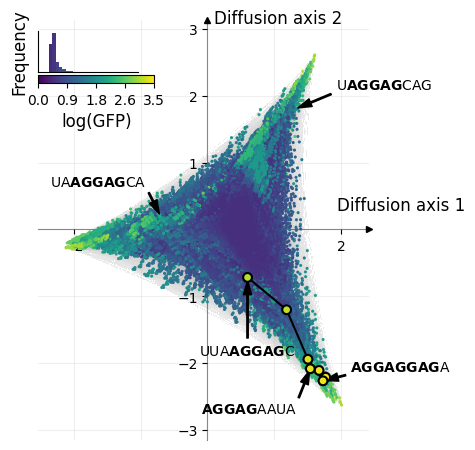

In [151]:
# fig, axes = plt.subplots(1, 1, figsize=(7.5, 7.5))
x, y = '1', '2'
dsg = dplot.plot_edges(td_nodes_df, edges_df=edges_df, resolution=800, x=x, y=y).opts(padding=0.1)

fig = dplot.dsg_to_fig(dsg)
fig.set_size_inches((6.5, 6))
axes = fig.axes[0]

plot_landscape(axes, td_nodes_df, x=x, y=y, #edf=edges_df,
               cmap_label='log(GFP)')

axes.set(aspect='equal')

annotate_seq(axes, 'UUAAGGAGC', r'UUA$\bf{AGGAG}$C', td_nodes_df,
             dx=0, dy=-1., ha='center', va='top', x=x, y=y)
annotate_seq(axes, 'UAAGGAGCA', r'UA$\bf{AGGAG}$CA', td_nodes_df,
             dx=-0.2, dy=0.4, ha='right', va='bottom', x=x, y=y)
annotate_seq(axes, 'AAGGAGCAG', r'U$\bf{AGGAG}$CAG', td_nodes_df,
             dx=0.6, dy=0.25, ha='left', va='bottom', x=x, y=y)

seqs = ['AGGAGAAUA', 'AGGAGGAUA', 'AGGAGGAGA',
        'AGGAGGAGC',
        'UGGAGGAGC', 'UUGAGGAGC', 'UUAAGGAGC',
       ]
annotate_seq(axes, 'AGGAGAAUA', r'$\bf{AGGAG}$AAUA', td_nodes_df,
             dx=-0.2, dy=-.5, ha='right', va='top', x=x, y=y)
annotate_seq(axes, 'AGGAGGAGC', r'$\bf{AGGAGGAG}$A', td_nodes_df,
             dx=0.4, dy=0.1, ha='left', va='bottom', x=x, y=y)


plot_path(axes, td_nodes_df, seqs)


#fig.tight_layout()
fig

In [ ]:
fig.savefig('figures/thermodynamic_model.visualization.png', dpi=300)

/tmp/ipykernel_1121828/1728480387.py:22: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'),
/tmp/ipykernel_1121828/1728480387.py:25: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axes.annotate('Diffusion axis {}'.format(x), xy=(0.85, 0.35), xycoords=('axes fraction', 'data'),


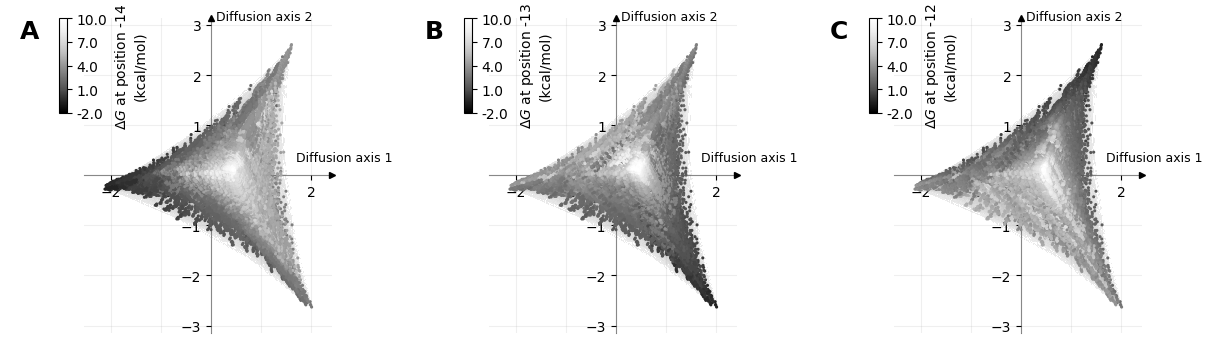

In [11]:
x, y = '1', '2'
edges_dsg = dplot.plot_edges(td_nodes_df, edges_df=edges_df, resolution=800, x=x, y=y).opts(padding=0.1)
fig = dplot.dsg_to_fig(edges_dsg + edges_dsg + edges_dsg)

for i, axes in enumerate(fig.axes):
    nodes_cbar_axes = axes.inset_axes((-0.1, 0.7, 0.03, 0.3))
    plot.plot_nodes(axes, td_nodes_df, x=x, y=y, 
                    sort_by='3', sort_ascending=True, 
                    color='dg{}'.format(i + 3), size=5, cmap='Greys_r',
                    cbar_axes=nodes_cbar_axes,
                    cbar_label='$\Delta G$ at position {}\n(kcal/mol)'.format(-14 + i),
                    cbar_orientation='vertical',
                    vmin=-2, vmax=10)
    axes.set(aspect='equal', xlabel='', ylabel='')
    axes.spines['left'].set(position=('data', 0), zorder=0,alpha=0.5)
    axes.spines['bottom'].set(position=('data', 0), zorder=0, alpha=0.5)
    axes.grid(alpha=0.2)
    axes.plot((1), (0), ls="", marker=">", ms=5, color="k",
              transform=axes.get_yaxis_transform(), clip_on=False)
    axes.plot((0), (1), ls="", marker="^", ms=5, color="k",
            transform=axes.get_xaxis_transform(), clip_on=False)
    axes.annotate('Diffusion axis {}'.format(y), xy=(0.1,  0.98), xycoords=('data', 'axes fraction'), 
                  textcoords='offset points', fontsize=9,
                  ha='left', va='bottom')
    axes.annotate('Diffusion axis {}'.format(x), xy=(0.85, 0.35), xycoords=('axes fraction', 'data'), 
                    textcoords='offset points', fontsize=9,
                    ha='left', va='center')
    sns.despine(ax=axes)

        
#nodes_cbar_axes.set_xlabel(cmap_label, fontsize=12)
fig.set_size_inches((4*3, 3.5))
#fig.tight_layout()
fig

In [12]:
fig.savefig('figures/thermodynamic_model.visualization_shifts.png', dpi=300)